In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install -U -q keras-nlp --no-deps

import os
os.environ['KERAS_BACKEND'] = 'jax'

#### **Import Necessary Packages!**

In [5]:
import warnings
warnings.filterwarnings('ignore')

import keras
import keras_nlp
import numpy as np
import PIL
import requests
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re

Version:

In [6]:
keras.__version__

'3.2.1'

Backend

In [9]:
keras.config.backend()

'jax'

#### Some Helper Functions:

In [10]:
def crop_and_resize(image, target_size):
    width, height = image.size
    source_size = min(image.size)
    left = width // 2 - source_size // 2
    top = height // 2 - source_size // 2
    right, bottom = left + source_size, top + source_size
    return image.resize(target_size, box=(left, top, right, bottom))


def read_image(url, target_size):
    contents = io.BytesIO(requests.get(url).content)
    image = PIL.Image.open(contents)
    image = crop_and_resize(image, target_size)
    image = np.array(image)
    # Remove alpha channel if neccessary.
    if image.shape[2] == 4:
        image = image[:, :, :3]
    return image

def parse_bbox_and_labels(detokenized_output: str):
    matches = re.finditer(
        "<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>"
        " (?P<label>.+?)( ;|$)",
        detokenized_output,
    )
    labels, boxes = [], []
    fmt = lambda x: float(x) / 1024.0
    for m in matches:
        d = m.groupdict()
        boxes.append([fmt(d["y0"]), fmt(d["x0"]), fmt(d["y1"]), fmt(d["x1"])])
        labels.append(d["label"])
    return np.array(boxes), np.array(labels)


def display_boxes(image, boxes, labels, target_image_size):
    h, l = target_size
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(boxes.shape[0]):
        y, x, y2, x2 = boxes[i] * h
        width = x2 - x
        height = y2 - y
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=1, edgecolor="r", facecolor="none"
        )
        # Add label
        plt.text(x, y, labels[i], color="red", fontsize=12)
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

## Load the model from Kaggle Models

Now we can load the PaliGemma "causal language model" from the Kaggle Models hub. A causal language model is just a LLM that is ready for generation, by training with a causal mask, and running generation a token at a time in a recurrent loop.

Quantization

In [11]:
keras.config.set_floatx('bfloat16')
pali_gemma_lm = keras_nlp.models.PaliGemmaCausalLM.from_preset(
    "pali_gemma_3b_mix_224"
)
pali_gemma_lm.summary()

Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...

Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)          │                                             257,152 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2048)        │   2,923,335,408 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     526,647,296 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,923,335,408 (5.45 GB)

 Trainable params: 2,923,335,408 (5.45 GB)

 Non-trainable params: 0 (0.00 B)

### Test PaliGemma Inference

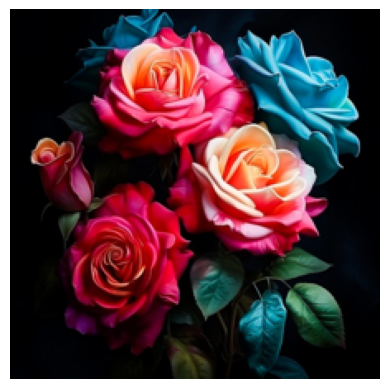

In [16]:
# Crop the image to the desired dimensions
target_size = (224, 224)
image_url = 'https://img.freepik.com/premium-photo/bunch-beautiful-rose-flowers-nature-ai-generated-image_305467-1.jpg'
image = read_image(image_url, target_size)

fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')  # Disable coordinate display
plt.show()

> Here's a generation call with a single image and prompt. The prompt should always end with \n.

In [18]:
prompt = '1. How many flowers do you see? Tell me thier colors and types?\n'
output = pali_gemma_lm.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)

1. How many flowers do you see? Tell me thier colors and types?
5


> Here is a object detection example

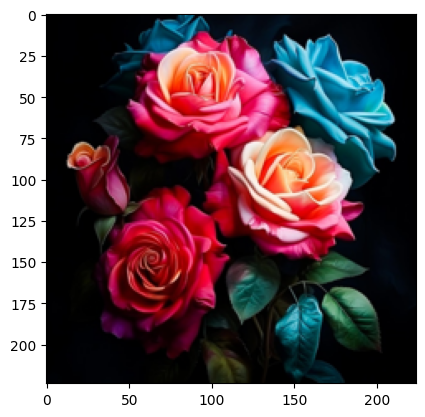

In [19]:
prompt = 'detect flowers\n'
output = pali_gemma_lm.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
boxes, labels = parse_bbox_and_labels(output)
display_boxes(image, boxes, labels, target_size)

Here's a generation call with batched inputs.

In [20]:
prompts = [
    'answer en how many flowers do you see?\n',
    'answer en what color does each flower have?\n',
    'describe en\n',
    'detect the leaves all at one boundary\n',
    'segment flowers\n',
]
images = [image, image, image, image, image]
outputs = pali_gemma_lm.generate(
    inputs={
        "images": images,
        "prompts": prompts,
    }
)
for output in outputs:
    print(output)

answer en how many flowers do you see?
6
answer en what color does each flower have?
pink
describe en
In this image we can see flowers and leaves.
detect the leaves all at one boundary
<loc0000><loc0058><loc1021><loc0957> the leaves all at one boundary
segment cow



## There's a few other style of prompts this model can handle out of the box...

* "cap {lang}\n": very raw short caption (from WebLI-alt).
* "caption {lang}\n": nice, coco-like short captions.
* "describe {lang}\n": somewhat longer more descriptive captions.
* "ocr\n": optical character recognition.
* "answer en {question}\n": question answering about the image contents.
* "question {lang} {answer}\n": question generation for a given answer.
* "detect {thing} ; {thing}\n": count objects in a scene.\
<font color = 'blue'>Try them out!

[Low Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685){:.external} is a fine-tuning technique which greatly reduces the number of trainable parameters for downstream tasks by freezing the weights of the model and inserting a smaller number of new weights into the model. This makes training with LoRA much faster and more memory-efficient, and produces smaller model weights (a few hundred MBs), all while maintaining the quality of the model outputs.

This tutorial walks you through using KerasNLP to perform LoRA fine-tuning on a Gemma 2B model using the [Databricks Dolly 15k dataset](https://www.kaggle.com/datasets/databricks/databricks-dolly-15k){:.external}. This dataset contains 15,000 high-quality human-generated prompt / response pairs specifically designed for fine-tuning LLMs.

#### Setup

#### Get access to Gemma

To complete this tutorial, you will first need to complete the setup instructions at Gemma setup. The [Gemma setup](https://ai.google.dev/gemma/docs/setup) instructions show you how to do the following:

In [ ]:
!pip install -q -U keras>=3

In [ ]:
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

### Resources

1. https://www.kaggle.com/code/awsaf49/paligemma-quick-start

2. https://www.kaggle.com/code/nilaychauhan/fine-tune-gemma-models-in-keras-using-lora

# <font color = 'green'> Fine-Tuning PaliGemma with Jax

This notebook shows how to fine-tune PaliGemma on a vision-language task with JAX. Fine-tuning is a process that can improve your model's performance on specific tasks or help the model adhere to specific output requirements when instructions aren't sufficient and you have a set of examples that demonstrate the outputs you want. Gemma-based models like PaliGemma require fine-tuning to produce expected results.

## What's in this notebook

**This notebook uses the model reference implementation from [big_vision](https://github.com/google-research/big_vision) and shows how to:**

* Install dependencies, and download the PaliGemma model checkpoint and training data
* Load the model onto GPU devices
* Prepare the model's inputs for training and inference
* Fine-tune the model
* Inspect the output

<font color = 'green'> The training data for this notebook consists of 90 pairs of images and long captions describing them. To make it runnable on a Kaggle GPU runtime, you'll only fine-tune the attention layers of the language model and freeze the other parameters.

This example is for learning purposes only. In a real use case, the amount of data, trainable parameters, training steps and hyper-parameters, and obtained results could be significantly different.

Before going through this notebook, you should be familiar with Python code, as well as how large language models (LLMs) are trained. You don't need to be familiar with JAX, but basic knowledge about JAX (or similar technologies such as Keras) is helpful when reading through the example code.

#### **Setup**

The following sections explain the preliminary steps for getting a notebook to use a PaliGemma model, including model access and configuring the notebook runtime.

**Select the runtime**
* To complete this tutorial, you'll need to have a Kaggle runtime with sufficient resources to run the PaliGemma model. In this case, you can use a GPU:

In the upper-right of the Kaggle notebook window, click on the three dots.
* Select Accelerator.
* Choose GPU P100 or GPU T4 x2 from the available options.

Fetch the big_vision repository and install related dependencies.
Download the big_vision repository to your Kaggle notebook from GitHub and install dependencies related to big_vision by running the following code.


In [1]:
!git install https://github.com/google-research/big_vision.git
!pip install -U "jax[cuda12]"

git: 'install' is not a git command. See 'git --help'.

The most similar command is
	instaweb
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 50.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 MB 19.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 MB 18.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 49.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.1/895.1 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━

In [3]:
import os
import sys

!git clone --quiet --branch=main --depth=1 \
    https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

fatal: destination path 'big_vision_repo' already exists and is not an empty directory.


Import JAX and other dependencies\
Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [4]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

2024-05-26 21:01:08.945476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 21:01:08.945604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 21:01:09.070655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_34/337604371.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


JAX version:  0.4.28
JAX platform: gpu
JAX devices:  2


**Download and configure the model**\
In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

**Download the model checkpoint**

PaliGemma includes several model variations. For this tutorial, you'll use the base JAX/FLAX PaliGemma 3B weight model.

Download the float16 version of the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [5]:
import os
import kagglehub

MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

DATA_DIR="./longcap100"
if not os.path.exists(DATA_DIR):
  print("Downloading the dataset...")
  !gsutil -m -q cp -n -r gs://longcap100/ .
  print(f"Data path: {DATA_DIR}")

Attaching 'paligemma-3b-pt-224.f16.npz' from model 'google/paligemma/jax/paligemma-3b-pt-224' to your Kaggle notebook...


Model path: /kaggle/input/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Copying gs://big_vision/paligemma_tokenizer.model...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model
Data path: ./longcap100


**Configure the model**
It's time to actually start configuring the model that you're going to use.

For this notebook, you need to be able to fit your model onto a GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be frozen when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the model_config as a FrozenConfigDict so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma Model class using the model_config as its configurations
* Load the model parameters into RAM
* Define a decode function to sample outputs from the model
* This code in this cell takes about a minute to run to completion.

In [6]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in a notebook.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

**Move model parameters into GPU/TPU memory**\
Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as float16, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [7]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the notebook runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

### Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

Create model inputs
The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* `preprocess_image`: Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* `preprocess_tokens`: Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* `postprocess_tokens`: Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.

In [8]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)